# Latent dynamics tests
## Optimising latent space dynamics for computational efficiency

The ODE we are solving in the MACE architecture is based on the one of chemical kinetics:

\begin{equation}
\frac{\text{d}z_{i}}{\text{d}t} \ = \ C_{i} + A_{ij} z_{j}+B_{ijk}z_jz_k
\end{equation}

More details can be found in [Maes et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240503274M/abstract).

In [1]:
import torch
import torchode          as to
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
from os import listdir
from natsort                import natsorted

from tqdm   import tqdm
from time   import time

from matplotlib             import rcParams, rc
rcParams.update({'figure.dpi': 200})
rc('font', family='serif')
rc('text', usetex=True)

### Functions


In [20]:
def g(t, z, args):
    '''
    ODE function of the latent dynamics. 
    '''
    A, B, C = args

    return C + torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z) 
        


def make_args(n_latent):
    '''
    Initialise tensors C, A, and B for the ODE function.
    '''
    C = torch.randn(n_latent)
    A = torch.randn(n_latent, n_latent)
    B = torch.randn(n_latent, n_latent, n_latent)

    return A,B,C

def make_setup(n_batch, n_latent, dt):
    '''
    Create the correct input torch tensors, given
        - the batch size, n_batch
        - the size of the latent space, n_latent.
    
    Creates randomised latent vector with values between -1 and 1.
    '''

    ## Randomised latent vector
    z0 = torch.rand(n_latent)*2-1

    ## Initial conditions
    t0 = 0.0

    ## End time and time step
    t1 = 1.e0
    # dt = 1.0e-2
    t_eval = torch.arange(t0, t1, step=dt)

    ## Create batches
    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch        = torch.rand(n_batch,n_latent) *2-1

    return t_eval_batch, z0_batch, dt


def solver(args, atol, rtol, n_batch, n_latent,dt, DEVICE):
    '''
    Solves the ODE for the latent dynamics.
    This code is a match with the solver in the MACE architecture.
    '''
    t_eval,z_0,dt = make_setup(n_batch, n_latent,dt)

    odeterm = to.ODETerm(g, with_args=True)
    step_method          = to.Dopri5(term=odeterm)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=odeterm)
    adjoint              = to.AutoDiffAdjoint(step_method, step_size_controller).to(DEVICE) # type: ignore

    jit_solver = torch.compile(adjoint)

    problem = to.InitialValueProblem(
        y0     = z_0,  ## "view" is om met de batches om te gaan
        t_eval = t_eval,
    )

    solution = jit_solver.solve(problem, args=args)

    return t_eval,solution.ys.data, dt


def remove_num_noise(sol, lim):
    '''
    Remove all solutions that diverge or are NaN.

    The parameter *lim* indicates the maximum value of the accepted solutions.

    '''
    w = np.where(np.logical_or(np.abs(sol) > lim, np.isnan(sol)))
    idx = [0]
    for i in range(1,len(w[0])):
        if w[0][i] != w[0][i-1]:
            idx.append(i)

    return w,np.array(idx)

def get_dynamics(sol, lim= 10, plot = False):
    '''
    Get the dynamics of the latent space.
    
    Calculates the dynamical evolution of the latent species.

    1. Remove all solutions that diverge or are NaN --> results in solutions z.
    2. Store & plot the dynamics of the latent space as the difference Δz with the input z0.
    '''

    if plot:
        fig, ax1 = plt.subplots(1,1,figsize=(6,3))
        a = 0.3

    w,idx = remove_num_noise(sol, lim)
    dyn = list()

    step = 1
    for n in tqdm(range(0,len(idx), step)):
        i = w[0][idx[n]]
        j = w[1][idx[n]]
        
        z = sol[i][:j]
        z0 = sol[i][0]
        Δz = z - z0
        dyn.append(Δz)

        if plot:
            ax1.plot(Δz, '-', alpha = a, label = i, lw = 1)
            # ax2.plot(z, '-', alpha = a, label = i)

    if plot:
        fs = 14
        fs2 = 12

        ax1.set_ylabel('$\\tilde{\\bf\\textit{z}}-\\tilde{\\bf\\textit{z}}_0$', fontsize = fs)
        # ax1.set_ylabel('$z-z_0$', fontsize = 12)
        # ax2.set_ylabel('$z$')

        ylim = 10.01
        xlim = 1000
        # for ax in axs:
        ax1.set_ylim([-ylim,ylim]) # type: ignore
        ax1.set_xlim([0,xlim])
        ax1.set_xlabel('time fraction', fontsize = fs)
        ax1.grid(True, linestyle = '--', linewidth = 0.2)
        # ax1.set(xticklabels=[])
        ax1.set_xlim([0,xlim]) # type: ignore
        ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize = fs2)

        fig.tight_layout()
        fig.subplots_adjust(hspace = 0.07)

        print('     >> Plotting...')
        plt.show()

    return idx, dyn

def get_sigma(idx, dyn, dt,cutoff,plot = False):
    '''
    Calculate the standard deviation of the latent dynamics, given a cutoff.
    '''
    
    if plot:
        a = 0.5
        fig, ax1 = plt.subplots(figsize=(8,4))

    sigmas = np.zeros([int(dt**(-1)),len(idx)])
    for i in tqdm(range(len(dyn))):   
        sigma = torch.std(dyn[i], axis = 1)
        # print(i,sigma)
        for j in range(len(sigma)-1):
            # print(j)
            sigmas[j][i] = sigma[j]

        if plot:
            ax1.plot(sigma, '-x', lw = 0.5, markersize = 1, alpha = a)

    h = list()
    for j in range(sigmas.shape[0]):
        h.append(1-(len(np.where(sigmas[j] == 0)[0])/sigmas.shape[1]))
    h= np.array(h)

    stds = list()
    for i in range(len(sigmas)):
        if h[i] >= cutoff:
            mu = np.mean(sigmas[i][sigmas[i] != 0 ])
            stds.append(mu)

    if plot:
        fs2 = 12
        fs = 14
        ax1.plot(stds, '-x', lw = 1, markersize = 1.5, color = 'k', label = 'mean $\\sigma$')

        ax1.set_ylabel('$\\sigma$', fontsize = fs)
        ax1.set_xlim([0,1000]) # type: ignore
        ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize = fs2)
        ax1.set_xlabel('time faction', fontsize = fs)
        plt.legend(fontsize = fs2)

        print('     >> Plotting...')
        plt.show()

    return sigmas,stds


def dynamics_test(n_latent, n_batch,lim, dt,atol, rtol, cutoff,DEVICE, plot = False):
    '''
    Main function to calculate the dynamics of the latent space.
    '''

    print('\n-------------------------')
    print('Input:')
    print('     - n_latent', n_latent)
    print('     - n_batch ', n_batch)
    print('     - atol    ', atol)
    print('     - rtol    ', rtol)

    args = make_args(n_latent)

    print(' >> Solving the ODE...')
    t,sol,dt = solver(args, atol, rtol, n_batch, n_latent, dt, DEVICE)

    print(' >> Getting the latent dynamics...')
    idx, dyn = get_dynamics(sol, lim, plot)
    
    print(' >> Calculating standard deviations...')
    sigmas, stds = get_sigma(idx, dyn, dt,cutoff,plot)

    return stds

### Setting up the latent dynamics test

In [21]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

# n_latents = [2, 3, 4, 5, 8, 10, 12, 16, 20, 25, 32, 48, 64, 128]
n_latents = [8]
n_batch  = 1000
dt = 1.e-3
cutoff = 0.95


atol = 1.0e-5
rtol = 1.0e-2

plot = True

## Calculating & saving the latent dynamics



-------------------------
Input:
     - n_latent 8
     - n_batch  1000
     - atol     1e-05
     - rtol     0.01
 >> Solving the ODE...
 >> Getting the latent dynamics...


100%|██████████| 999/999 [00:20<00:00, 48.66it/s]
/tmp/ipykernel_8074/3444932763.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize = fs2)


     >> Plotting...


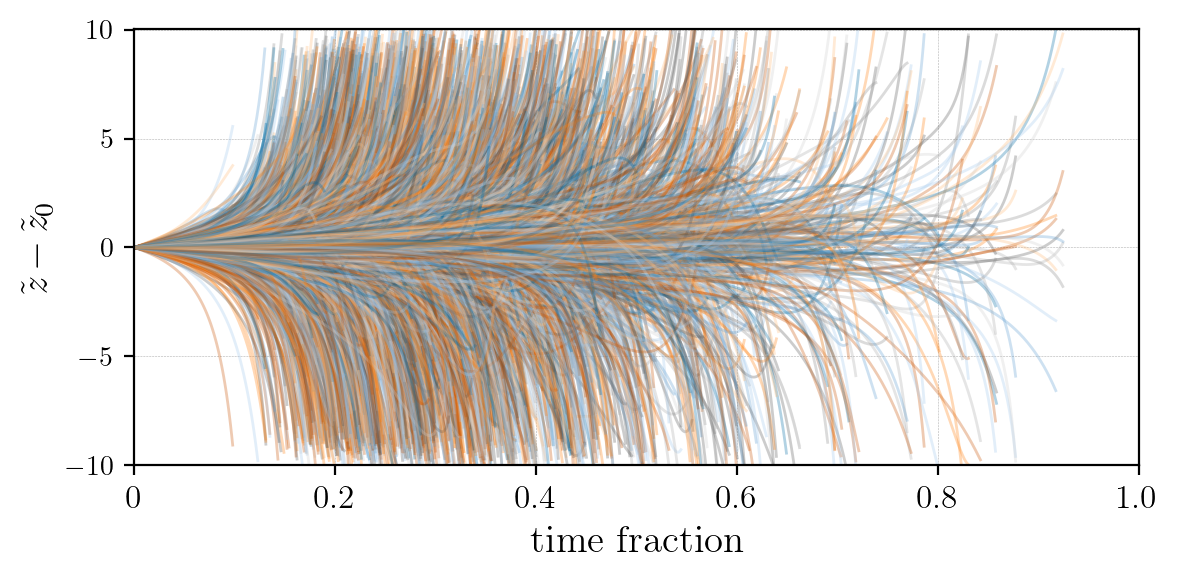

 >> Calculating standard deviations...


100%|██████████| 999/999 [00:04<00:00, 209.79it/s]
/tmp/ipykernel_8074/3444932763.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize = fs2)


     >> Plotting...


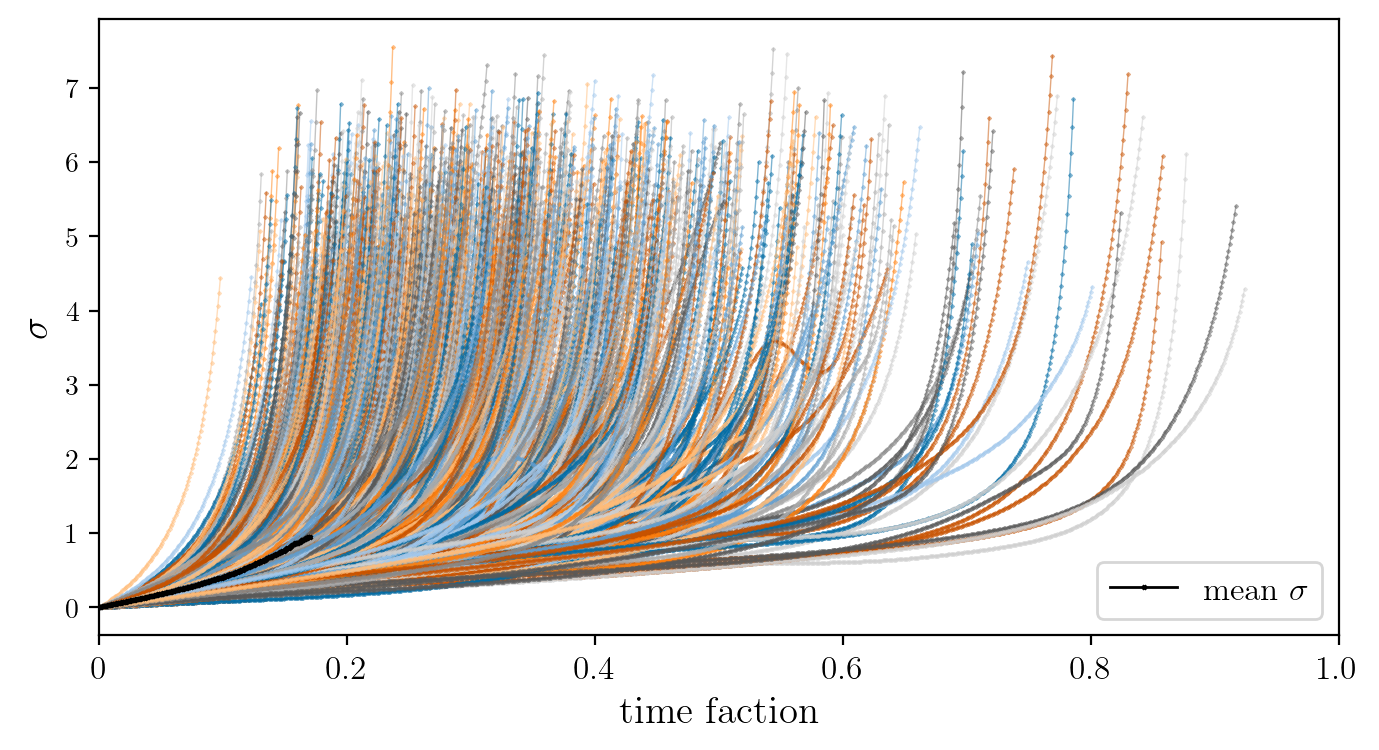


len std 0.171


In [22]:
stds = list()
for i in range(len(n_latents)):
    std = dynamics_test(n_latents[i], n_batch,lim, dt, atol, rtol, cutoff, DEVICE, plot = True)
    print('\nlen std',len(std)*dt)
    stds.append(std)


### Saving the latent dynamics tests

In [18]:
for i in range(len(stds)):
    np.save('/STER/silkem/MACE/latentdyn/nlatent_'+str(n_latents[i]), stds[i])

## Retrieving the latent dynamics

In [8]:
loc = '/STER/silkem/MACE/latentdyn/'

files = listdir(loc)
print(files)
files.remove('latent_dynamics.ipynb')
files.remove('first_try')
files.remove('second_try')
files.remove('latent_dyn_tests.py')
files.remove('all_dyntests.png')
files = natsorted(files)

print('--')
print(files)

latent_dyn = dict()
n_latents = list()

for file in files:
    print(file)
    n = int(file[8:-4])
    print(n)
    latent_dyn[n] = np.load(loc+file)
    n_latents.append(n)


['nlatent_48.npy', 'nlatent_8.npy', 'nlatent_25.npy', 'nlatent_10.npy', 'first_try', 'second_try', 'nlatent_32.npy', 'nlatent_64.npy', 'nlatent_16.npy', 'all_dyntests.png', 'nlatent_12.npy', 'nlatent_20.npy', 'nlatent_3.npy', 'nlatent_4.npy', 'nlatent_128.npy', 'nlatent_5.npy', 'nlatent_2.npy', 'latent_dynamics.ipynb', 'latent_dyn_tests.py']
--
['nlatent_2.npy', 'nlatent_3.npy', 'nlatent_4.npy', 'nlatent_5.npy', 'nlatent_8.npy', 'nlatent_10.npy', 'nlatent_12.npy', 'nlatent_16.npy', 'nlatent_20.npy', 'nlatent_25.npy', 'nlatent_32.npy', 'nlatent_48.npy', 'nlatent_64.npy', 'nlatent_128.npy']
nlatent_2.npy
2
nlatent_3.npy
3
nlatent_4.npy
4
nlatent_5.npy
5
nlatent_8.npy
8
nlatent_10.npy
10
nlatent_12.npy
12
nlatent_16.npy
16
nlatent_20.npy
20
nlatent_25.npy
25
nlatent_32.npy
32
nlatent_48.npy
48
nlatent_64.npy
64
nlatent_128.npy
128


In [9]:
latn_dim = list()
time_fract = list()

for key in latent_dyn.keys():
    if key != 3 and key != 5 and key != 10 and key != 12 and key != 20 and key != 25  and key != 48 :
        print(key, len(latent_dyn[key])/1000)
        latn_dim.append(key)
        time_fract.append(len(latent_dyn[key])/1000)

2 0.969
4 0.296
8 0.221
16 0.117
32 0.062
64 0.033
128 0.017


/tmp/ipykernel_8074/1869005217.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize = fs2)


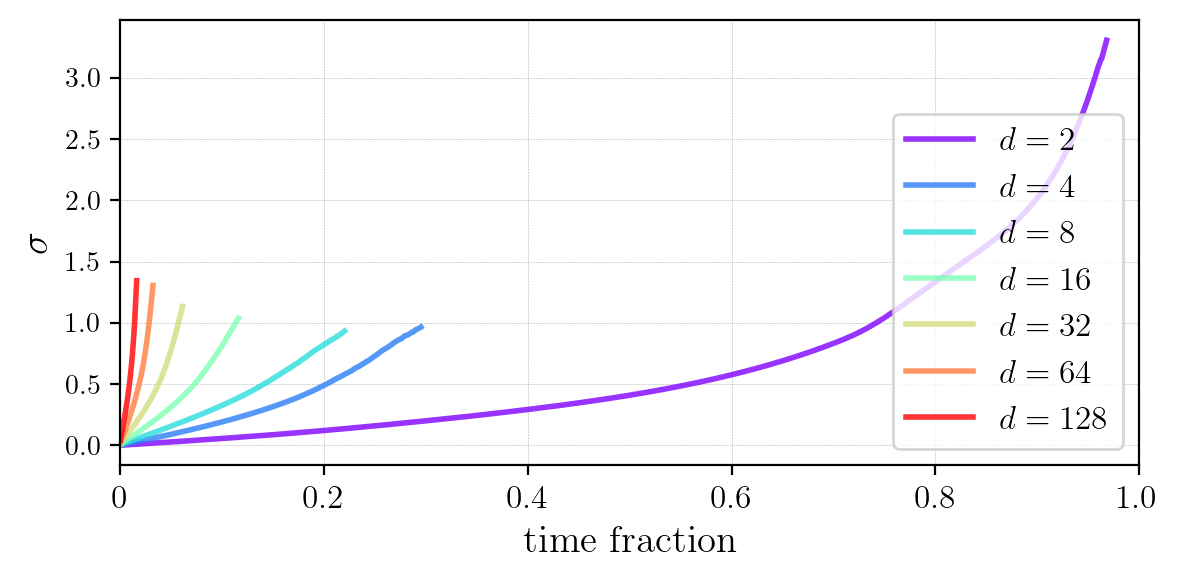

In [17]:
colors = mpl.cm.rainbow(np.linspace(0, 1, len(time_fract)))

fig, ax1 = plt.subplots(figsize=(6,3))
plt.style.use('tableau-colorblind10')
a = 0.8
fs = 14
fs2 = 12

for i in range(len(time_fract)):
    key = latn_dim[i]
    # print(str(n_latents[i]))
    # print(i)
    # if i != 0 :
    ax1.plot(latent_dyn[key], ls='-',marker = '', lw = 2, markersize = 3, color = colors[i], label = '$d='+str(key)+'$', alpha = a)

ax1.grid(True, which='both',linestyle = '--', linewidth = 0.2)
ax1.set_xlim([0,1000]) # type: ignore
ax1.set_xticklabels([0,0.2,0.4,0.6,0.8,1.0], fontsize = fs2)
ax1.set_ylabel('$\\sigma$', fontsize = fs)
ax1.set_xlabel('${\\rm time\ fraction}$', fontsize = fs)
ax1.legend(fontsize = fs2, loc = 'lower right')

fig.tight_layout()

savepath = '/lhome/silkem/Documents/MyPapers/2023_mace/paper-MACE/'
plt.savefig(savepath+'all_dyntests.png')


plt.show()

/tmp/ipykernel_8074/3742107665.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lab_lant, fontsize = fs2)


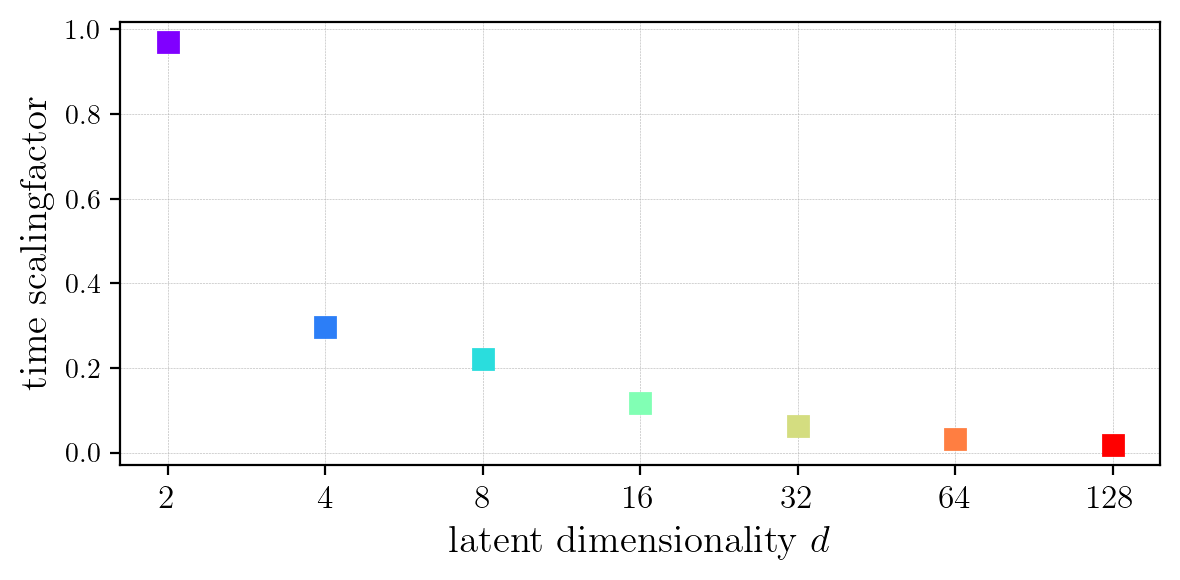

In [19]:
fig, ax1 = plt.subplots(figsize=(6,3))

for i in range(len(latn_dim)):

    ax1.plot(np.log2(latn_dim[i]), time_fract[i], 's', lw = 1, markersize = 7, color = colors[i])


fs = 14
fs2 = 12

lab_lant = [1,2,4,8,16,32,64, 128]

# ax1.set_xticks(np.array(lab_lant))


ax1.set_xticklabels(lab_lant, fontsize = fs2)

ax1.grid(True, which='both',linestyle = '--', linewidth = 0.2)
# ax1.set_xscale('log')

ax1.set_ylabel('${\\rm time\ scaling factor}$', fontsize = fs)
ax1.set_xlabel('${\\rm latent\ dimensionality }\ d$', fontsize = fs)
fig.tight_layout()

savepath = '/lhome/silkem/Documents/MyPapers/2023_mace/paper-MACE/'

# plt.savefig('timefract_dyntests.png')
plt.savefig(savepath+'timefract_dyntests.png')


plt.show()